<a href="https://colab.research.google.com/github/FilledEther20/Feature_Selection_Hybrid_MPA-CFHO/blob/main/HybridMPA_CFHO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chaotic Maps Defined

In [ ]:

def logistic_map(x, r=3.99):
      return r * x * (1 - x)

def tent_map(x, mu=1.99):
      if x < 0.5:
          return mu * x
      else:
          return mu * (1 - x)

#Pure Fire Hawk Optimizer


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
class FHO():
    """ Class for FHO
    ---------
    self.cost_function: function to optimize
    self.Pop : np.array of Generated Solution Candidates of shape (pop_size,n_dims)
    self.n_dims: dimension of the problem
    self.pop_size : Number of solution candidates (int)
    self.min_bounds : numpy array of dimension (n_dims,) containing the MIN value for each variable
    self.max_bounds : numpy array of dimension (n_dims,) containing the MAX value for each variable
    self.max_generations: Maximum number of generated candidates (int)
    self.best_costs: python list of best costs (list)
    self.costs_iter : python list of cost calculated in each MAIN iteration (list)
    self.minimal_p : minimal point as a numpy array of dimensions (n_dims,)
    self.path :  A list containing the trajectory of the best hawks
    """

    def __init__(self, min_bounds , max_bounds, pop_size, cost_function , max_generations=200):
        self.max_generations = max_generations
        self.min_bounds      = min_bounds
        self.max_bounds      = max_bounds
        self.cost_function   = cost_function
        self.pop_size        = pop_size
        self.n_dims          = len(min_bounds) #Number of decision variables
        self.Pop             = np.random.uniform(min_bounds,max_bounds,(pop_size,self.n_dims)) #Initial Solution candidates (pop_size,n_dims)
        self.best_costs      = []
        self.costs_iter      = []
        self.minimal_p       = None
        self.path            = []

    def territories(self,Fire_Hawks,Preys):
        '''
        Inputs:
        self
        Fire_Hawks : np.array of fire hawks of dim (num_Hawks,self.n_dims)
        Preys : np.array of preys od dim (self.pop_size-num_Hawks,self.n_dims)

        Output:
        territories : territory of each hawk in a dictionary of nested numpy arrays
        '''
        #Computing territories using the euclidien distance
        preys_left=Preys.copy()
        territories={i:np.array([]) for i in range(len(Fire_Hawks))}
        for i in range(len(Fire_Hawks)):
            #distance with respect to Fire hawk i
            D=np.linalg.norm(Fire_Hawks[i]-preys_left,axis=1)

            #Get territory of fire Hawk i
            sorted_preys_idx=np.argsort(D)
            alpha=np.random.randint(1,len(preys_left)-1) if len(preys_left)-1>1 else 1
            my_preys=sorted_preys_idx[:alpha]
            territories[i]=preys_left[my_preys]
            preys_left=preys_left[sorted_preys_idx[alpha:]]
            if len(preys_left)==0:
                break
        if len(preys_left)>0:
            territories[len(Fire_Hawks)-1]=np.array(list(territories[len(Fire_Hawks)-1])+list(preys_left))
        return territories


    def minimize_FHO(self):
        '''
        Input:
        self

        Output:
        GB : global best solution (min f(x))
        self.minimal_p minimal point as a numpy array of dimensions (n_dims,)
        '''
        ## Fire hawk algorithm to minimize the cost function
        n_dims=self.n_dims
        Pop=self.Pop
        pop_size=self.pop_size
        max_generations = self.max_generations
        min_bounds=self.min_bounds
        max_bounds=self.max_bounds
        cost_function = self.cost_function

        #Evaluate the cost function for all candidate vectors
        cost= np.array([cost_function(Pop[i]) for i in range(pop_size)])

        #Randomly set a number of Hawks between 1 and 20% of pop_size
        num_Hawks = np.random.randint(1,int(pop_size/5)+1) if 1<int(pop_size/5)+1 else 1

        #Ordering candidates
        Pop = Pop[np.argsort(cost)]
        cost.sort()
        SP=Pop.mean(axis=0)


        #Select fire hawks
        Fire_Hawks= Pop[:num_Hawks]

        #Select the Preys dim(pop_size-num_Hawks,n_dims)
        Preys = Pop[num_Hawks:]

        #get territories
        territories=self.territories(Fire_Hawks,Preys)

        #update best
        GB=cost[0]
        Best_Hawk=Pop[0]
        self.path.append(Best_Hawk)

        #Counter
        FEs=pop_size

        ## Main Loop
        while FEs < max_generations:
            Pop_Tot=[]
            cost=[]
            #Movement of Fire Hawk for all territories
            for i in territories:
                PR=territories[i].copy()
                FHl=Fire_Hawks[i].copy()
                SPl=PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
                a,b=np.random.uniform(0,1,size=2)
                FHnear  =Fire_Hawks[np.random.randint(num_Hawks)]
                FHl_new =FHl+(a*GB-b*FHnear)
                FHl_new = np.maximum(FHl_new,min_bounds)
                FHl_new = np.minimum(FHl_new,max_bounds)
                Pop_Tot.append(list(FHl_new))

                #Movement of the preys following Fire Hawks movement
                for q in range(len(PR)):
                    a,b=np.random.uniform(0,1,size=2)
                    PRq_new1=PR[q].copy()+((a*FHl-b*SPl))
                    PRq_new1= np.maximum(PRq_new1,min_bounds)
                    PRq_new1 = np.minimum(PRq_new1,max_bounds)
                    Pop_Tot.append(list(PRq_new1))

                    #Movement of the preys outside of territory
                    a,b      =np.random.uniform(0,1,size=2)
                    FHAlter  =Fire_Hawks[np.random.randint(num_Hawks)]
                    PRq_new2 =PR[q].copy()+((a*FHAlter-b*SP));
                    PRq_new2 = np.maximum(PRq_new2,min_bounds)
                    #The following line for PRq_new2 differs from original algorithm in matlab code (max instead of min):
                    # Effects observed through our testing:
                    # 1/ It converges faster and the costs of the subsequent iterations will tend to decrease (less chaotic behavior than with np.minimun)
                    # 2/ In higher dimensions, it converge to the right solution! (while with np.minimum it does not)
                    PRq_new2 = np.maximum(PRq_new2,max_bounds)
                    Pop_Tot.append(list(PRq_new2))

            #Get cost
            Pop_Tot=np.array(Pop_Tot)
            for i in range(len(Pop_Tot)):
                cost.append(cost_function(Pop_Tot[i]))
                FEs = FEs+1

            #Create a new population of Hawks and Preys
            order_idx=np.argsort(cost)
            cost.sort()
            Pop_Tot=np.array(Pop_Tot)[order_idx]
            num_Hawks = np.random.randint(1,int(pop_size/5)+1) if 1<int(pop_size/5)+1 else 1
            Best_Pop=Pop_Tot[0]
            SP=Pop_Tot.mean(axis=0)
            Fire_Hawks=Pop_Tot[:num_Hawks]
            Preys=Pop_Tot[num_Hawks:]

            #Get new territories
            territories=self.territories(Fire_Hawks,Preys)

            # Update Global Best cost (if relevant)
            if cost[0]<GB:
                Best_Position=Best_Pop
                GB=cost[0]
                self.best_costs.append(GB)
                self.minimal_p=Fire_Hawks[0]
                self.path.append(Best_Position)
            else:
                self.best_costs.append(GB)

            #Track the iteration calculated cost
            self.costs_iter.append(cost[0])

        #Return Global Best and argmin
        return (GB,self.minimal_p)
    def plot_costs(self):
        #Plot cost evolution
        vals=self.costs_iter
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Iteration's calculated Cost")
        plt.plot(np.arange(n),vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def plot_log_costs(self):
        #Plot cost evolution
        vals=np.log(self.costs_iter)
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Log Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Log Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def get_path(self):
      return np.array(self.path).T


#Chaotic Fire Hawk Optimizer

In [ ]:
class Chaotic_FHO:
    def __init__(self, min_bounds , max_bounds, pop_size, cost_function , max_generations=200):
        self.max_generations = max_generations
        self.min_bounds      = min_bounds
        self.max_bounds      = max_bounds
        self.cost_function   = cost_function
        self.pop_size        = pop_size
        self.n_dims          = len(min_bounds) #Number of decision variables
        self.Pop             = np.random.uniform(min_bounds,max_bounds,(pop_size,self.n_dims)) #Initial Solution candidates (pop_size,n_dims)
        self.best_costs      = []
        self.costs_iter      = []
        self.minimal_p       = None
        self.path            = []

    def territories(self,Fire_Hawks,Preys):
        '''
        Inputs:
        self
        Fire_Hawks : np.array of fire hawks of dim (num_Hawks,self.n_dims)
        Preys : np.array of preys od dim (self.pop_size-num_Hawks,self.n_dims)

        Output:
        territories : territory of each hawk in a dictionary of nested numpy arrays
        '''
        #Computing territories using the euclidien distance
        preys_left=Preys.copy()
        territories={i:np.array([]) for i in range(len(Fire_Hawks))}
        for i in range(len(Fire_Hawks)):
            #distance with respect to Fire hawk i
            D=np.linalg.norm(Fire_Hawks[i]-preys_left,axis=1)
            #Get territory of fire Hawk i
            sorted_preys_idx=np.argsort(D)
            alpha=np.random.randint(1,len(preys_left)-1) if len(preys_left)-1>1 else 1
            my_preys=sorted_preys_idx[:alpha]
            territories[i]=preys_left[my_preys]
            preys_left=preys_left[sorted_preys_idx[alpha:]]
            if len(preys_left)==0:
                break
        if len(preys_left)>0:
            territories[len(Fire_Hawks)-1]=np.array(list(territories[len(Fire_Hawks)-1])+list(preys_left))
        return territories


    def minimize_FHO(self):
        '''
        Input:
        self

        Output:
        GB : global best solution (min f(x))
        self.minimal_p minimal point as a numpy array of dimensions (n_dims,)
        '''
        ## Fire hawk algorithm to minimize the cost function
        n_dims=self.n_dims
        Pop=self.Pop
        pop_size=self.pop_size
        max_generations = self.max_generations
        min_bounds=self.min_bounds
        max_bounds=self.max_bounds
        cost_function = self.cost_function

        #Evaluate the cost function for all candidate vectors
        cost= np.array([cost_function(Pop[i]) for i in range(pop_size)])

        #Randomly set a number of Hawks between 1 and 20% of pop_size
        num_Hawks = np.random.randint(1,int(pop_size/5)+1) if 1<int(pop_size/5)+1 else 1

        #Ordering candidates
        Pop = Pop[np.argsort(cost)]
        cost.sort()
        SP=Pop.mean(axis=0)


        #Select fire hawks
        Fire_Hawks= Pop[:num_Hawks]

        #Select the Preys dim(pop_size-num_Hawks,n_dims)
        Preys = Pop[num_Hawks:]

        #get territories
        territories=self.territories(Fire_Hawks,Preys)

        #update best
        GB=cost[0]
        Best_Hawk=Pop[0]
        self.path.append(Best_Hawk)

        #Counter
        FEs=pop_size

        ## Main Loop
        while FEs < max_generations:
            Pop_Tot=[]
            cost=[]
            #Movement of Fire Hawk for all territories
            for i in territories:
                PR=territories[i].copy()
                FHl=Fire_Hawks[i].copy()
                SPl=PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
                a,b=np.random.uniform(0,1,size=2)
                FHnear  =Fire_Hawks[np.random.randint(len(Fire_Hawks))]

                #Update Fire Hawk's position (FHl_new) using chaotic maps
                FHl_new = FHl + (a * GB - b * FHnear)
                FHl_new = np.maximum(FHl_new, min_bounds)
                FHl_new = np.minimum(FHl_new, max_bounds)
                Pop_Tot.append(list(FHl_new))

                # Apply chaotic map to perturb the new position
                chaos_factor = logistic_map(np.random.rand())
                FHl_new = FHl_new + chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                FHl_new = np.maximum(FHl_new, min_bounds)
                FHl_new = np.minimum(FHl_new, max_bounds)
                Pop_Tot.append(list(FHl_new))
            for q in range(len(PR)):
                a,b=np.random.uniform(0,1,size=2)
                PRq_new1 = PR[q].copy() + ((a * FHl - b * SPl))
                PRq_new1 = np.maximum(PRq_new1, min_bounds)
                PRq_new1 = np.minimum(PRq_new1, max_bounds)

                # Apply chaotic map to perturb the prey's position
                chaos_factor = tent_map(np.random.rand())
                PRq_new1 = PRq_new1 + chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                PRq_new1 = np.maximum(PRq_new1, min_bounds)
                PRq_new1 = np.minimum(PRq_new1, max_bounds)

                Pop_Tot.append(list(PRq_new1))

                # Movement of the preys outside of territory
                a,b = np.random.uniform(0,1,size=2)
                FHAlter = Fire_Hawks[np.random.randint(num_Hawks)]
                PRq_new2 = PR[q].copy() + ((a * FHAlter - b * SP))
                PRq_new2 = np.maximum(PRq_new2, min_bounds)
                PRq_new2 = np.minimum(PRq_new2, max_bounds)

                # Apply chaotic map to perturb the prey's alternative movement
                chaos_factor = logistic_map(np.random.rand())
                PRq_new2 = PRq_new2 + chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                PRq_new2 = np.maximum(PRq_new2, min_bounds)
                PRq_new2 = np.minimum(PRq_new2, max_bounds)

                Pop_Tot.append(list(PRq_new2))

            #Get cost
            Pop_Tot=np.array(Pop_Tot)
            for i in range(len(Pop_Tot)):
                cost.append(cost_function(Pop_Tot[i]))
                FEs = FEs+1

            #Create a new population of Hawks and Preys
            order_idx=np.argsort(cost)
            cost.sort()
            Pop_Tot=np.array(Pop_Tot)[order_idx]
            num_Hawks = np.random.randint(1,int(pop_size/5)+1) if 1<int(pop_size/5)+1 else 1
            Best_Pop=Pop_Tot[0]
            SP=Pop_Tot.mean(axis=0)
            Fire_Hawks=Pop_Tot[:num_Hawks]
            Preys=Pop_Tot[num_Hawks:]

            #Get new territories
            territories=self.territories(Fire_Hawks,Preys)

            # Update Global Best cost (if relevant)
            if cost[0]<GB:
                Best_Position=Best_Pop
                GB=cost[0]
                self.best_costs.append(GB)
                self.minimal_p=Fire_Hawks[0]
                self.path.append(Best_Position)
            else:
                self.best_costs.append(GB)

            #Track the iteration calculated cost
            self.costs_iter.append(cost[0])

        #Return Global Best and argmin
        return (GB,self.minimal_p)
    def plot_costs(self):
        #Plot cost evolution
        vals=self.costs_iter
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Iteration's calculated Cost")
        plt.plot(np.arange(n),vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def plot_log_costs(self):
        #Plot cost evolution
        vals=np.log(self.costs_iter)
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Log Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Log Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def get_path(self):
      return np.array(self.path).T




#Benchmarking Function with the Chaotic Fire Hawk Optimizer

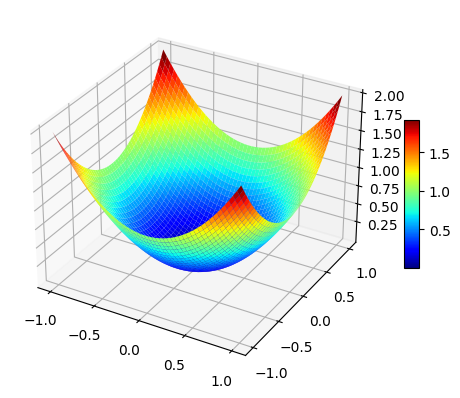

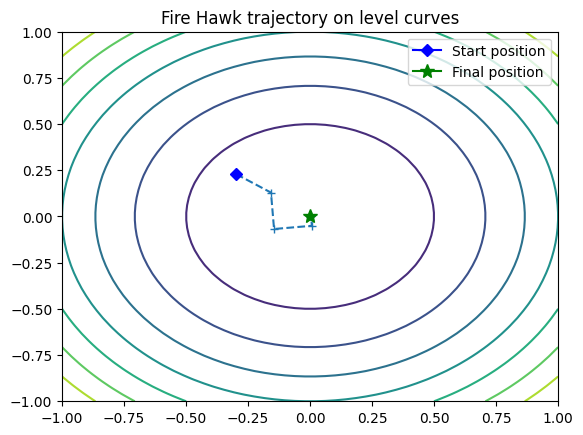

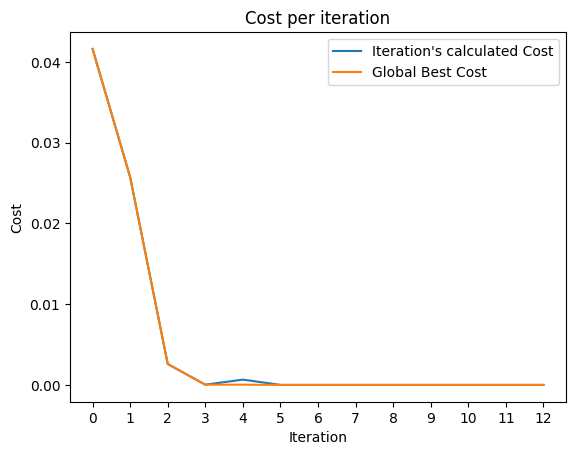

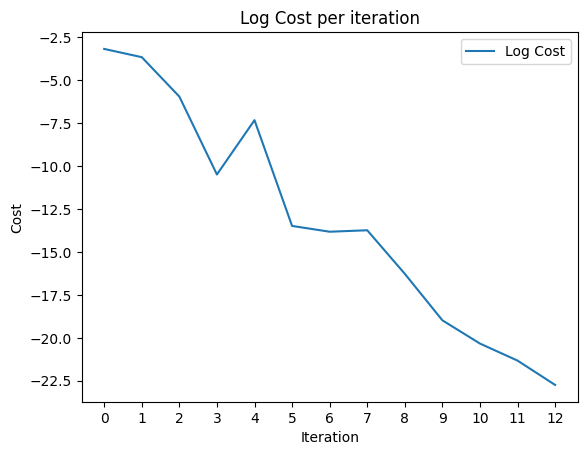


 Global best cost is  1.3280925008136086e-10

 Global best position is  [8.37978755e-06 7.91128376e-06]


In [ ]:
def f(x1,x2):
  a= x1**2+x2**2
  return a
x1= np.linspace(-1,1)
x2= np.linspace(-1,1)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.add_subplot( projection='3d')
my_cmap = plt.get_cmap('jet')
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10)
plt.show()

fonction=lambda x : np.linalg.norm(x)**2

minD=[-5,-5]
maxD=[5,5]

opti=FHO(minD , maxD, pop_size=200, cost_function = fonction, max_generations=2000000)
a,b=opti.minimize_FHO()
x_1,x_2=opti.get_path()


#Plot Fire Hawk trajectory on level curves and cost function
plt.contour(x,y,results)
plt.plot(x_1, x_2, linestyle='--',marker='+')
plt.plot(x_1[0],x_2[0], marker='D', color='b',markersize=6, label="Start position")
plt.plot(x_1[-1],x_2[-1], marker='*', color='green', markersize=10, label="Final position")
plt.legend()
plt.title("Fire Hawk trajectory on level curves")
opti.plot_costs()
opti.plot_log_costs()
#Print global best
print("\n Global best cost is ", a)
print("\n Global best position is ", b)

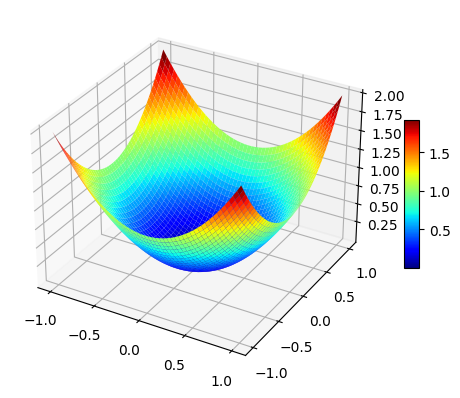

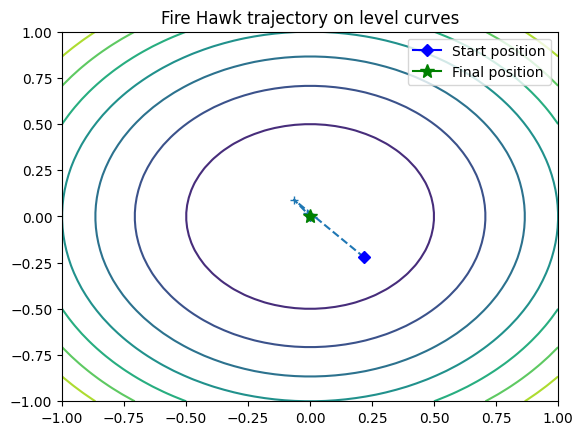

KeyboardInterrupt: 

In [ ]:
x1= np.linspace(-1,1)
x2= np.linspace(-1,1)
x,y= np.meshgrid(x1,x2)
results = f(x, y)

figure = plt.figure()
axis = figure.add_subplot( projection='3d')
my_cmap = plt.get_cmap('jet')
surface=axis.plot_surface(x, y, results, cmap=my_cmap, shade= "false")
figure.colorbar(surface, ax = axis, shrink = 0.4, aspect = 10)
plt.show()

fonction=lambda x : np.linalg.norm(x)**2

minD=[-5,-5]
maxD=[5,5]

opti=Chaotic_FHO(minD , maxD, pop_size=200, cost_function = fonction, max_generations=2000000)
a,b=opti.minimize_FHO()
x_1,x_2=opti.get_path()


#Plot Fire Hawk trajectory on level curves and cost function
plt.contour(x,y,results)
plt.plot(x_1, x_2, linestyle='--',marker='+')
plt.plot(x_1[0],x_2[0], marker='D', color='b',markersize=6, label="Start position")
plt.plot(x_1[-1],x_2[-1], marker='*', color='green', markersize=10, label="Final position")
plt.legend()
plt.title("Fire Hawk trajectory on level curves")
opti.plot_costs()
opti.plot_log_costs()
#Print global best
print("\n Global best cost is ", a)
print("\n Global best position is ", b)